In [1]:
!pip install -qq diffusers datasets accelerate wandb open-clip-torch

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generic pretrained generator

In [7]:
from diffusers import DDPMPipeline

pretrained_generic = "google/ddpm-cifar10-32"
ptg_pipe = DDPMPipeline.from_pretrained(pretrained_generic)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

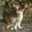

In [10]:
ptg_img = ptg_pipe().images[0]
ptg_img

# Architecture-specific

In [11]:
pretrained_church = "google/ddpm-ema-church-256"
ptc_pipe = DDPMPipeline.from_pretrained(pretrained_church)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
ptc_img = ptc_pipe().images[0]
ptc_img

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
scheduler = DDIMScheduler.from_pretrained(pretrained_church)
scheduler.set_timesteps(num_inference_steps=40)

0it [00:00, ?it/s]

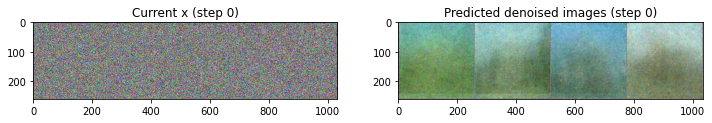

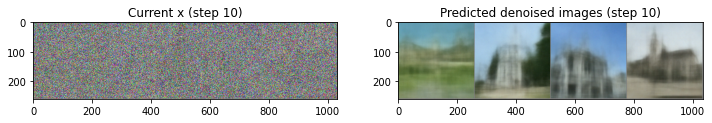

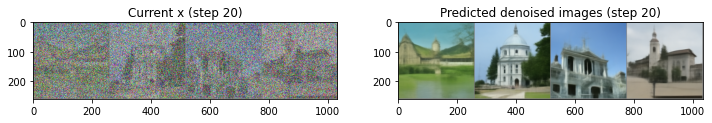

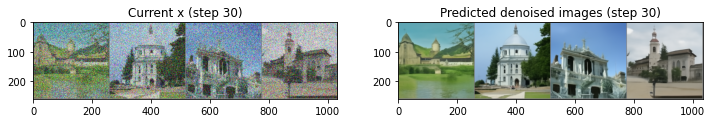

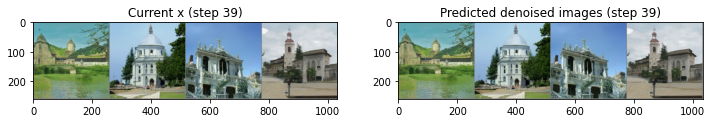

In [15]:
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare model input
    model_input = scheduler.scale_model_input(x, t)

    # Get the prediction
    with torch.no_grad():
        noise_pred = ptc_pipe.unet(model_input, t)["sample"]

    # Calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Update x
    x = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = (
            scheduler_output.pred_original_sample
        )  # Not available for all schedulers
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

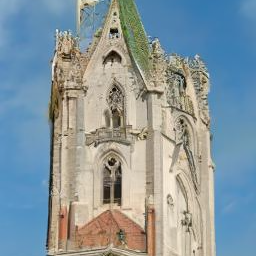

In [16]:
ptc_pipe.scheduler = scheduler
images = ptc_pipe(num_inference_steps=40).images
images[0]

Found cached dataset imagefolder (/Users/benlehrburger/.cache/huggingface/datasets/benlehrburger___imagefolder/benlehrburger--architecture-87edb277c75f0e75/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Previewing batch:


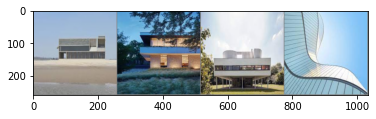

In [17]:
dataset_name = "benlehrburger/architecture"
dataset = load_dataset(dataset_name, split="train")
image_size = 256
batch_size = 4
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 0 average loss: 0.028101157269312744


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1 average loss: 0.01159277943640648


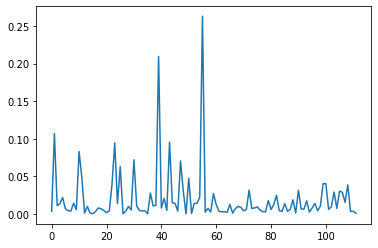

In [20]:
num_epochs = 2
lr = 1e-5
grad_accumulation_steps = 2

optimizer = torch.optim.AdamW(ptc_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            ptc_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = ptc_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = ptc_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}"
    )

# Plot the loss curve:
plt.plot(losses)

0it [00:00, ?it/s]

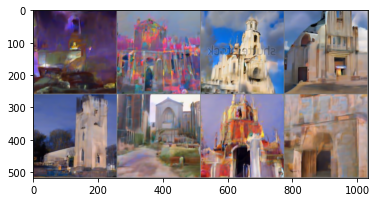

In [22]:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = ptc_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

In [24]:
ptc_pipe.save_pretrained("LSUN-church-finetuned-modern-model")

In [25]:
# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
model_name = "LSUN-church-finetuned-modern-model"  
local_folder_name = "LSUN-church-finetuned-modern-model"  # @param Created by the script or one you created via image_pipe.save_pretrained('save_name')
description = "LSUN pretrained church unconditional image generation model naively finetuned with modern architecture data"  # @param
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{local_folder_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{local_folder_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{local_folder_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

'https://huggingface.co/benlehrburger/LSUN-church-finetuned-modern-model/blob/main/model_index.json'

In [26]:
# Add a model card (optional but nice!)
content = f"""
---
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# LSUN pretrained church unconditional image generation model naively finetuned with modern architecture data

{description}

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/benlehrburger/LSUN-church-finetuned-modern-model/blob/main/README.md'